## Model description

This cruise control benchmark was already used in [1] for testing the decompositional stability verification approach. We suggest it here as a benchmark for testing verification tools. It has in particular a service and emergency brakes. The proposed hybrid model takes in addition the braking behavior of the engine under consideration. A detailed description can be found on pages 128, 129 and 130 of [1].

    v is the difference between the actual and the desired velocity.
    t is the time.
    x is an auxiliary variable.

The hybrid automaton of the benchmark:

This model has 3 continuous variables, 2 modes and 2 discrete jumps.

The syste can be represented as the following hybrid automaton:

<img src="CruiseControl.png" alt="Drawing" style="width: 500px;"/>

The model parameters and description are taken from the [HyPro collection of continuous and hybrid system benchmarks](https://ths.rwth-aachen.de/research/projects/hypro/benchmarks-of-continuous-and-hybrid-systems/), see the [Rod Reactor model](https://ths.rwth-aachen.de/research/projects/hypro/rod-reactor/).

---

*References:*

[1] F. Vaandrager. Lecture notes: Hybrid Systems.

In [1]:
using Revise # to debug
using Reachability, HybridSystems, MathematicalSystems, LazySets, LinearAlgebra
using Plots, LaTeXStrings

┌ Warning: Package LazySets does not have Expokit in its dependencies:
│ - If you have LazySets checked out for development and have
│   added Expokit as a dependency but haven't updated your primary
│   environment's manifest file, try `Pkg.resolve()`.
│ - Otherwise you may need to report an issue with LazySets
│ Loading Expokit into LazySets from project dependency, future warnings for LazySets are suppressed.
└ @ nothing nothing:840


In [83]:
rm = ConstrainedResetMap(2, 

ConstrainedResetMap{Float64,Hyperrectangle{Float64}}(2, Hyperrectangle{Float64}([-0.29191, -1.18135, -1.30961], [0.251299, 0.530119, 0.347717]), Dict(2=>0.0))

In [85]:
rmap = LazySets.ResetMap(rand(Hyperrectangle, dim=3), Dict(2=>0.0))

LazySets.ResetMap{Float64,Hyperrectangle{Float64}}(Hyperrectangle{Float64}([-0.479707, -1.8103, 0.136767], [0.912688, 0.0849094, 1.63069]), Dict(2=>0.0))

In [87]:
Matrix(get_A(rmap))

3×3 Array{Float64,2}:
 1.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  1.0

In [94]:
Vector(LazySets.get_b(rmap))

3-element Array{Float64,1}:
 0.0
 0.0
 0.0

In [26]:
function rod_reactor(;X0=Singleton([510.0, 20.0, 20.0]),
                      T=5.0,
                      ε=1e-6)

    # automaton structure
    automaton = LightAutomaton(4)

    # rod_1  : x' = Ax + b
    A = [0.1 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0]
    b = [-56.0, 1.0, 1.0]
    X = HPolyhedron([HalfSpace([-1.0, 0.0, 0.0], -510.0)]) # x >= 510
    rod_1 = ConstrainedAffineContinuousSystem(A, b, X)
    
    # no_rods
    b = [-50.0, 1.0, 1.0]
    X = HPolyhedron([HalfSpace([1.0, 0.0, 0.0], 550.0)])   # x <= 550
    no_rods = ConstrainedAffineContinuousSystem(A, b, X)

    # rod_2
    b = [-60.0, 1.0, 1.0]
    X = HPolyhedron([HalfSpace([-1.0, 0.0, 0.0], -510.0)])   # x >= 510
    rod_2 = ConstrainedAffineContinuousSystem(A, b, X)

    # shut_down
    X = Universe(2)
    shut_down = ConstrainedContinuousIdentitySystem(3, X)

    # modes
    modes = [rod_1, no_rods, rod_2, shut_down]

    add_transition!(automaton, 1, 2, 1)
    add_transition!(automaton, 2, 1, 2)
    add_transition!(automaton, 2, 3, 3)
    add_transition!(automaton, 3, 2, 4)
    add_transition!(automaton, 2, 4, 5)

    # guards
    G12 = HPolyhedron([HalfSpace([1.0, 0.0, 0.0], 510.0 + ε),
                       HalfSpace([-1.0, 0.0, 0.0], -510.0 + ε)]) # x = 510

    G21 = HPolyhedron([HalfSpace([1.0, 0.0, 0.0], 550.0 + ε),
                       HalfSpace([-1.0, 0.0, 0.0], -550.0 + ε),  # x = 550
                       HalfSpace([0.0, -1.0, 0.0], -20.0)])      # c1 >= 20

    G23 = HPolyhedron([HalfSpace([1.0, 0.0, 0.0], 550.0 + ε),
                       HalfSpace([-1.0, 0.0, 0.0], -550.0 + ε),  # x = 550
                       HalfSpace([0.0, 0.0, -1.0], -20.0)])      # c2 >= 20

    G32 = HPolyhedron([HalfSpace([1.0, 0.0, 0.0], 510.0 + ε),
                       HalfSpace([-1.0, 0.0, 0.0], -510.0 + ε)]) # x = 510

    G24 = HPolyhedron([HalfSpace([1.0, 0.0, 0.0], 550.0 + ε),
                       HalfSpace([-1.0, 0.0, 0.0], -550.0 + ε),  # x = 550
                       HalfSpace([1.0, 0.0, 0.0], 20.0),         # c1 < 20
                       HalfSpace([0.0, 1.0, 0.0], 20.0)])        # c2 < 20
    
    resetmaps = [ConstrainedResetMap(2, G12, Dict(2=>0.0)), 
                 ConstrainedIdentityMap(2, G21),
                 ConstrainedIdentityMap(2, G23),
                 ConstrainedResetMap(2, G32, Dict(3=>0.0)),
                 ConstrainedIdentityMap(2, G24)]

    # switching
    switchings = [AutonomousSwitching()]

    ℋ = HybridSystem(automaton, modes, resetmaps, switchings)

    # initial condition in "off_off" mode
    initial_condition = [(1, X0)]

    problem = InitialValueProblem(ℋ, initial_condition)

    options = Options(:mode=>"reach", :T=>T, :plot_vars=>[1, 3],
                      :project_reachset=>false)

    return (problem, options)
end

rod_reactor (generic function with 3 methods)

## Reachability settings

We consider an initial set of

$$
x = 510,~c_1 = c_2 = 20.
$$
The initial location is the location "No Rods" and the time horizon $T= 50s$.

The set of unreachable states are all states in location shut-down.

In [95]:
# settings
X0 = Singleton([510.0, 20.0, 20.0])
T = 5.0

RodReactor, options = rod_reactor(X0=X0, T=T, ε=0.0);

## Results

In [30]:
using Polyhedra

In [104]:
# BROKEN.. why?

#=
@time begin
    opC = BFFPSV18(:δ=>0.1)
    opD = LazyDiscretePost()
    sol = solve(RodReactor, options, opC, opD)
end;

the exact support vector of an intersection is not implemented
=#

In [113]:
# similar to approximating discrete post ... gives big overapprox error
# with default options
using LazySets.Approximations

@time begin
    opC = BFFPSV18(:δ=>0.1)
    opD = ApproximatingDiscretePost()
    sol = solve(RodReactor, options, opC, opD)
end;

[warn] Several option aliases were used for aliases Symbol[:check_invariant_intersection].
[warn] Several option aliases were used for aliases Symbol[:overapproximation].
[warn] Several option aliases were used for aliases Symbol[:lazy_R⋂I].
[warn] Several option aliases were used for aliases Symbol[:lazy_R⋂G].
[warn] Several option aliases were used for aliases Symbol[:lazy_A⌜R⋂G⌟⋂I].
  0.090466 seconds (69.48 k allocations: 4.796 MiB)


In [115]:
# similar to approximating discrete post ... gives big overapprox error
# with default options. we try to use oct direction but it doesn't use them
using LazySets.Approximations

@time begin
    opC = BFFPSV18(:δ=>0.1)
    opD = LazyDiscretePost(:check_invariant_intersection=>true,
                           :overapproximation=>OctDirections,
                           :lazy_R⋂I=>false,
                           :lazy_R⋂G=>false,
                           :lazy_A⌜R⋂G⌟⋂I=>false)
    sol = solve(RodReactor, options, opC, opD)
end;

[warn] Several option aliases were used for aliases Symbol[:check_invariant_intersection].
[warn] Several option aliases were used for aliases Symbol[:overapproximation].
[warn] Several option aliases were used for aliases Symbol[:lazy_R⋂I].
[warn] Several option aliases were used for aliases Symbol[:lazy_R⋂G].
[warn] Several option aliases were used for aliases Symbol[:lazy_A⌜R⋂G⌟⋂I].
  0.782626 seconds (6.43 M allocations: 227.672 MiB, 17.75% gc time)


In [116]:
# using Concrete Discrete Post
@time begin
    opC = BFFPSV18(:δ=>0.01)
    opD = ConcreteDiscretePost()
    sol = solve(RodReactor, options, opC, opD) # does it produce 
end;

  0.402832 seconds (679.60 k allocations: 41.510 MiB, 10.84% gc time)


In [117]:
using LazySets.Approximations: project, overapproximate

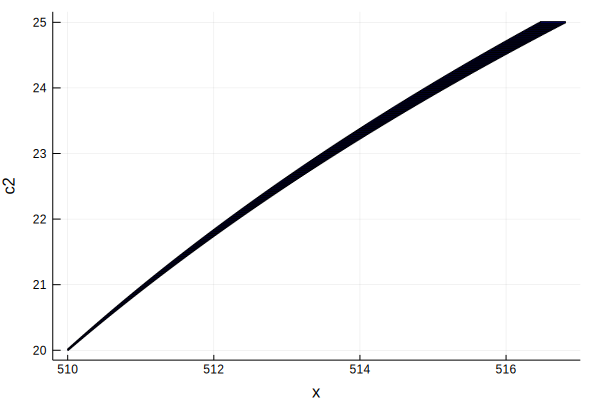

In [118]:
Xkproj = [project(sol.Xk[i].X, [1, 3], Hyperrectangle) for i in eachindex(sol.Xk)];
plot(Xkproj, xlab="x", ylab="c2")

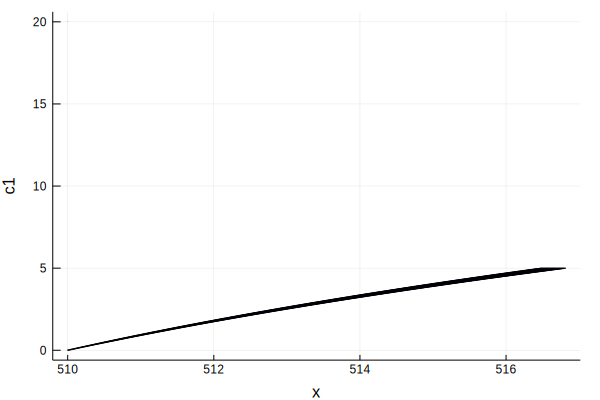

In [119]:
Xkproj = [project(sol.Xk[i].X, [1, 2], Hyperrectangle) for i in eachindex(sol.Xk)];
plot(Xkproj, xlab="x", ylab="c1")

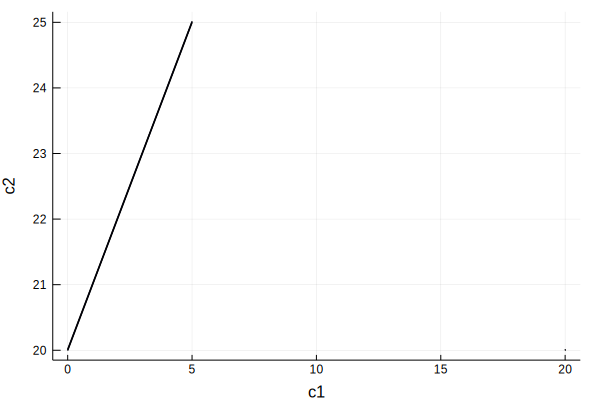

In [120]:
Xkproj = [project(sol.Xk[i].X, [2, 3], Hyperrectangle) for i in eachindex(sol.Xk)];
plot(Xkproj, xlab="c1", ylab="c2")